In [1]:
import tensorflow as tf

class ResnetIdentityBlock(tf.keras.Model):
  def __init__(self, kernel_size, filters, batch_normalization=True, conv_first=False):
    super(ResnetIdentityBlock, self).__init__(name='')
    
    self.residual_layers = []
    
    for i in range(len(filters)):
        
        if conv_first:
            setattr(self, 'conv' + str(i+1), tf.keras.layers.Conv2D(filters[i], kernel_size, padding='same'))
            self.residual_layers.append('conv' + str(i+1))

            if batch_normalization:
                setattr(self, 'bn' + str(i+1), tf.keras.layers.BatchNormalization())
                self.residual_layers.append('bn' + str(i+1))
        
        else:
            if batch_normalization:
                setattr(self, 'bn' + str(i+1), tf.keras.layers.BatchNormalization())
                self.residual_layers.append('bn' + str(i+1))
            
            setattr(self, 'conv' + str(i+1), tf.keras.layers.Conv2D(filters[i], kernel_size, padding='same'))
            self.residual_layers.append('conv' + str(i+1))

            
            
  def call(self, input_tensor, training=False):
    
    x = input_tensor
    
    for layer in self.residual_layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            x = getattr(self, layer)(x)
        else: 
            x = getattr(self, layer)(x, training=False)
        x = tf.nn.relu(x)
        
    x += input_tensor
    return tf.nn.relu(x)


from tensorflow.keras.datasets import cifar10

(x_train,y_train),(x_test,y_test) = cifar10.load_data() 

x_train = x_train /255
x_test = x_test / 255


y_train_orig = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=15,                                       #5,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.05)


In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow_addons as tfa

NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)

NUM_EPOCHS = 100
learning_rate = 1e-5
BATCH_SIZE=32

In [3]:
# Architecture
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=INPUT_SHAPE))

model.add(ResnetIdentityBlock((3,3), filters=(512, 512)))
model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))

model.add(ResnetIdentityBlock((3,3), filters=(256, 256)))
model.add(ResnetIdentityBlock((3,3), filters=(256, 256)))
model.add(ResnetIdentityBlock((3,3), filters=(256, 256)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))


model.add(ResnetIdentityBlock((3,3), filters=(128, 128)))
model.add(ResnetIdentityBlock((3,3), filters=(128, 128)))
model.add(ResnetIdentityBlock((3,3), filters=(128, 128)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))

model.add(ResnetIdentityBlock((2,2), filters=(64, 64)))
model.add(ResnetIdentityBlock((2,2), filters=(64, 64)))
model.add(ResnetIdentityBlock((2,2), filters=(64, 64)))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.AveragePooling2D(pool_size=8))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 512)       14336     
_________________________________________________________________
resnet_identity_block (Resne (None, 30, 30, 512)       4723712   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 256)       1179904   
_________________________________________________________________
resnet_identity_block_1 (Res (None, 30, 30, 256)       1182208   
_________________________________________________________________
resnet_identity_block_2 (Res (None, 30, 30, 256)       1182208   
_________________________________________________________________
resnet_identity_block_3 (Res (None, 30, 30, 256)       1182208   
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 128)       2

In [4]:
datagen.fit(x_train)

lr_schedule = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-6,
    maximal_learning_rate=1e-5,
    step_size=2000,
    scale_fn=lambda x: 1.,
    scale_mode="cycle",
    name="MyCyclicScheduler")

adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
    
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True, save_best_only=True)

In [5]:
model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, subset='training'),
                    validation_data=datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
                    steps_per_epoch= len(x_train) / BATCH_SIZE,
                    validation_steps = len(x_train) / BATCH_SIZE * 0.05,
                    epochs=NUM_EPOCHS,
                    callbacks=[es, mc])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1562.5 steps, validate for 78.125 steps
Epoch 1/100
1485/1562 [===========================>..] - ETA: 27s - loss: 207.3538 - accuracy: 0.0033WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 156250.0 batches). You may need to use the repeat() function when building your dataset.


In [6]:
history = model.history.history

KeyError: 'val_accuracy'

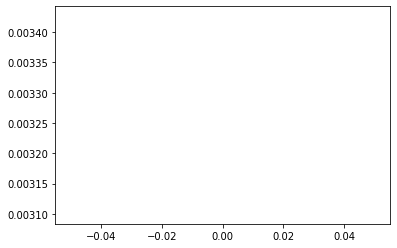

In [7]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()